In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
import random
InteractiveShell.ast_node_interactivity = "all"
import os
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import glob
from tqdm import tqdm

import plotly.figure_factory as ff
import plotly.express as px
import numpy as np

import lightgbm as lgb
from sklearn import metrics

/home/nlztrk/anaconda3/envs/wildfire/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


# Baseline Model

In [2]:
train = pd.read_csv("../data/train_val_test_data/train.csv")
valid = pd.read_csv("../data/train_val_test_data/valid.csv")
test = pd.read_csv("../data/train_val_test_data/test.csv")

In [3]:
features = [
    'latitude', 'longitude', 'month',
    'fire_cnt_before', 'fire_before',
    'fire_cnt_last_year', 'fire_last_year',
    'fire_cnt_last_year_same_month', 'fire_last_year_same_month',
    'temperature_min', 'temperature_max', 'temperature_avg'
]

In [4]:
train.columns

Index(['latitude', 'longitude', 'year', 'month', 'fire_cnt', 'fire',
       'fire_cnt_before', 'fire_before', 'fire_cnt_last_year',
       'fire_last_year', 'fire_cnt_last_year_same_month',
       'fire_last_year_same_month', 'latitude_rounded', 'longitude_rounded',
       'temperature_min', 'temperature_max', 'temperature_avg'],
      dtype='object')

In [5]:
test[features]

,latitude,longitude,month,fire_cnt_before,fire_before,fire_cnt_last_year,fire_last_year,fire_cnt_last_year_same_month,fire_last_year_same_month,temperature_min,temperature_max,temperature_avg
0,36.0,26.0,7,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1,36.0,26.0,6,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2,36.0,26.0,8,0.0,0.0,0.0,0.0,0.0,0.0,18.778766,30.234173,24.707707
3,36.0,26.0,9,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
4,36.0,26.0,5,0.0,0.0,0.0,0.0,0.0,0.0,10.817382,23.005025,16.740865
...,...,...,...,...,...,...,...,...,...,...,...,...
136795,41.9,44.9,3,0.0,0.0,0.0,0.0,0.0,0.0,0.023693,13.290325,6.320873
136796,41.9,44.9,10,0.0,0.0,0.0,0.0,0.0,0.0,5.971608,19.404413,12.526717
136797,41.9,44.9,2,0.0,0.0,0.0,0.0,0.0,0.0,-5.709199,6.822592,0.892644
136798,41.9,44.9,1,0.0,0.0,0.0,0.0,0.0,0.0,-6.877382,5.329408,-0.680617


In [6]:
train_data = lgb.Dataset(train[features], label=train.fire)
valid_data = lgb.Dataset(valid[features], label=valid.fire)

parameters = {'objective': 'binary',
              'metric': 'auc',
              'random_state': 1337,
#               'num_leaves': 100,
#               'max_depth': 100, 
              #'is_unbalance':True
             }
num_round = 500

model = lgb.train(parameters, train_data, num_round, valid_sets=[valid_data],
                  early_stopping_rounds=20, verbose_eval=50)

/home/nlztrk/anaconda3/envs/wildfire/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/nlztrk/anaconda3/envs/wildfire/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 4819, number of negative: 679181
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1204
[LightGBM] [Info] Number of data points in the train set: 684000, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007045 -> initscore=-4.948321
[LightGBM] [Info] Start training from score -4.948321
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.993371


In [7]:
test_predictions = model.predict(test[features])
test_binary_predictions = (test_predictions>=0.5).astype(int)

<AxesSubplot:>

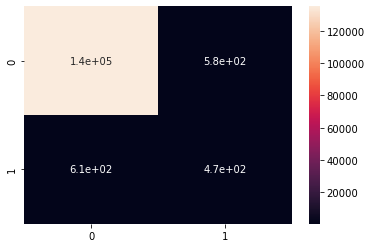

In [8]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test.fire, test_binary_predictions)
sns.heatmap(cm, annot=True)

In [9]:
from sklearn.metrics import classification_report
print(classification_report(test.fire, test_binary_predictions, target_names=["not fire", "fire"]))

              precision    recall  f1-score   support

    not fire       1.00      1.00      1.00    135722
        fire       0.45      0.43      0.44      1078

    accuracy                           0.99    136800
   macro avg       0.72      0.71      0.72    136800
weighted avg       0.99      0.99      0.99    136800



In [10]:
test_auc = metrics.roc_auc_score(test.fire, test_predictions)
test_auc

0.9912869101712578

In [11]:
# fpr, tpr, thr = metrics.roc_curve(test.fire, test_predictions)
# px.line(pd.DataFrame(dict(FPR=fpr, TPR=tpr)),
#         x='FPR', y='TPR', title='Fire/hotspot model performance for 2020')

<AxesSubplot:>

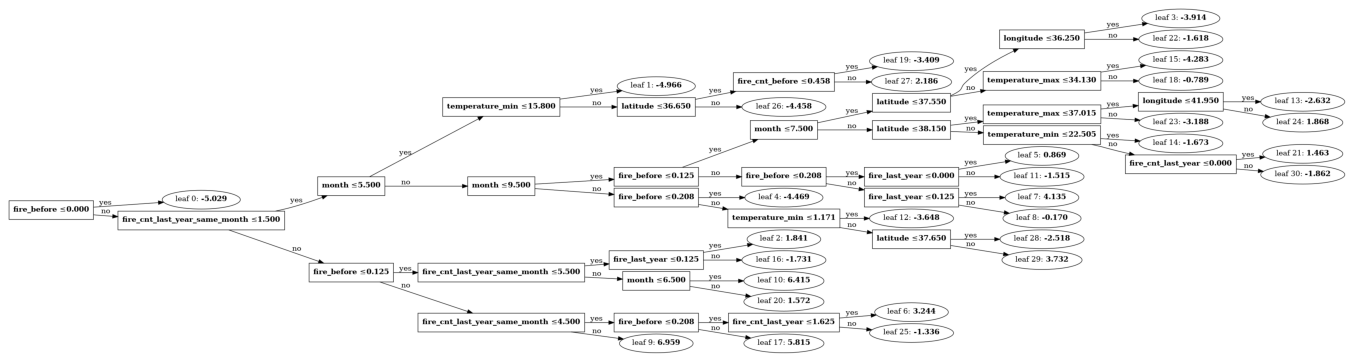

In [12]:
fig, ax = plt.subplots(figsize=(24, 18))
lgb.plot_tree(model, ax=ax)

In [13]:
model.save_model('../data/model_ckpt/model.txt')